In [21]:
#Import dependencies
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import datetime
import scipy.stats as stats
from scipy.stats import linregress

In [22]:
#Dave's Code

#Import EPA data, read into dataframe
epa_source = "epa_data/annual_aqi_by_county_all.csv"
epa_data = pd.read_csv(epa_source, index_col=0)

In [23]:
#Add a column for the common pollutant name, based on which of the days values had the largest number
epa_data['Common Pollutant'] = epa_data[['Days CO','Days NO2','Days Ozone','Days SO2','Days PM2.5','Days PM10']].idxmax(1).str.replace('Days ','')

#Add columns to the dataframe for percentages of types of days to give all rows a consistent frame of measure
epa_data['Pct Good Days'] = epa_data['Good Days'] / epa_data['Days with AQI']
epa_data['Pct Moderate Days'] = epa_data['Moderate Days'] / epa_data['Days with AQI'] 
epa_data['Pct Unhealthy for Sensitive Groups Days'] = epa_data['Unhealthy for Sensitive Groups Days'] / epa_data['Days with AQI'] 
epa_data['Pct Unhealthy Days'] = epa_data['Unhealthy Days'] / epa_data['Days with AQI'] 
epa_data['Pct Very Unhealthy Days'] = epa_data['Very Unhealthy Days'] / epa_data['Days with AQI'] 
epa_data['Pct Hazardous Days'] = epa_data['Hazardous Days'] / epa_data['Days with AQI'] 
epa_data.head()

epa_data.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,...,Days SO2,Days PM2.5,Days PM10,Common Pollutant,Pct Good Days,Pct Moderate Days,Pct Unhealthy for Sensitive Groups Days,Pct Unhealthy Days,Pct Very Unhealthy Days,Pct Hazardous Days
0,Alabama,Baldwin,2012,284,226,56,2,0,0,0,...,0,74,0,Ozone,0.795775,0.197183,0.007042,0.0,0.0,0.0
1,Alabama,Clay,2012,121,99,22,0,0,0,0,...,0,121,0,PM2.5,0.818182,0.181818,0.000000,0.0,0.0,0.0
2,Alabama,Colbert,2012,283,222,55,6,0,0,0,...,0,74,0,Ozone,0.784452,0.194346,0.021201,0.0,0.0,0.0
3,Alabama,DeKalb,2012,361,282,74,5,0,0,0,...,0,41,0,Ozone,0.781163,0.204986,0.013850,0.0,0.0,0.0
4,Alabama,Elmore,2012,245,212,33,0,0,0,0,...,0,0,0,Ozone,0.865306,0.134694,0.000000,0.0,0.0,0.0


In [24]:
#Export the munged EPA dataframe to a new CSV
epa_data.to_csv("epa_data/annual_aqi_by_county_all_munged.csv", sep=",", index=False, encoding='utf-8')

In [25]:
#Drop the rows containing data for Mexico and the Virgin Islands, since these are not in our Census data
epa_data = epa_data[epa_data["State"] != 'Country Of Mexico']
epa_data = epa_data[epa_data["State"] != 'Virgin Islands']

In [26]:
#Create a summary dataframe for year and common pollutant, counting the number of counties per year/pollutant
pollution_type_count = pd.DataFrame(epa_data.groupby(['Year','Common Pollutant'])['County'].count())

#Reset the index after the group by
pollution_type_count.reset_index(inplace = True)

#Pivot the dataframe, with year as the index and pollutants as the columns
pollution_type_count_pivot = pollution_type_count.pivot(index='Year', columns='Common Pollutant', values='County')

#Sort the pollutant types columns
pollution_type_count_pivot = pollution_type_count_pivot[['Ozone', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO']]

#display the pivot
pollution_type_count_pivot

Common Pollutant,Ozone,PM2.5,PM10,SO2,NO2,CO
Year,,,,,,
2012,609,363,52,34,6,3
2013,583,392,49,29,3,2
2014,585,389,42,28,4,2
2015,595,390,39,30,3,1
2016,655,318,39,32,6,1
2017,660,312,34,44,6,1


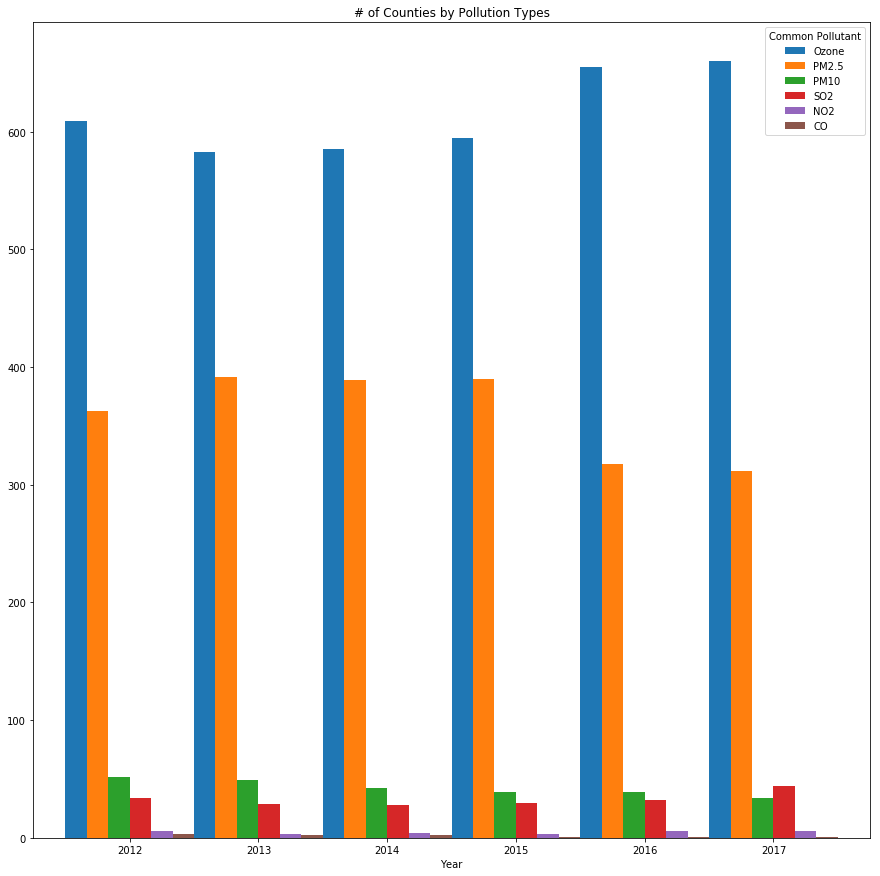

In [27]:
pollution_type_count_pivot.sort_values(by=['Year'], ascending=True).plot(kind='bar',width=1,stacked=False,figsize=(15,15),rot=0,title="# of Counties by Pollution Types")

In [28]:
#Create a dataframe organized by state and the average percentages of each of the AQI levels
epa_data_state_pcts = epa_data.groupby(['State'])['Pct Good Days', 'Pct Moderate Days',
       'Pct Unhealthy for Sensitive Groups Days', 'Pct Unhealthy Days',
       'Pct Very Unhealthy Days', 'Pct Hazardous Days'].mean()
#Print the dataframe
epa_data_state_pcts.head()

,Pct Good Days,Pct Moderate Days,Pct Unhealthy for Sensitive Groups Days,Pct Unhealthy Days,Pct Very Unhealthy Days,Pct Hazardous Days
State,,,,,,
Alabama,0.810722,0.184763,0.004152,0.000336,0.000027,0.000000
Alaska,0.869871,0.106059,0.012237,0.011416,0.000417,0.000000
Arizona,0.620954,0.315888,0.053046,0.008111,0.000807,0.000421
Arkansas,0.815497,0.181635,0.002591,0.000277,0.000000,0.000000
California,0.582489,0.332083,0.066943,0.016144,0.001303,0.000378


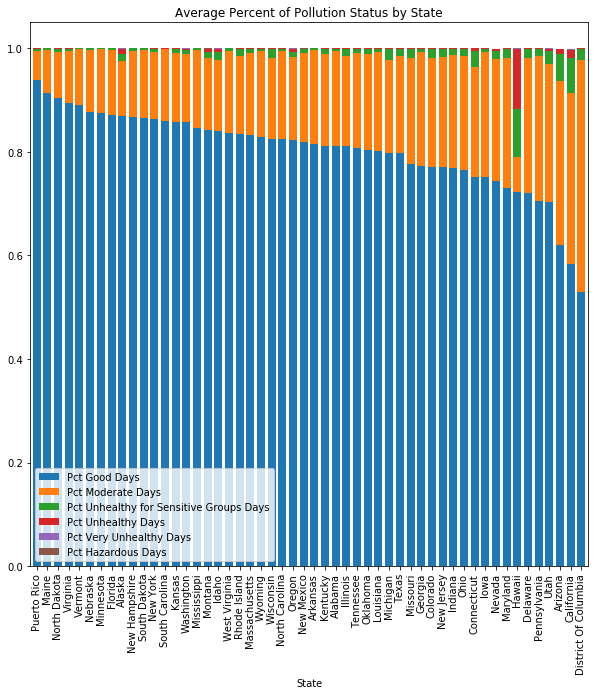

In [29]:
#Plot the dataframe as stacked bar chart
epa_data_state_pcts.sort_values(by='Pct Good Days', ascending=False).plot(kind='bar',stacked=True,width=.75,figsize=(10,10),rot=90,title="Average Percent of Pollution Status by State")

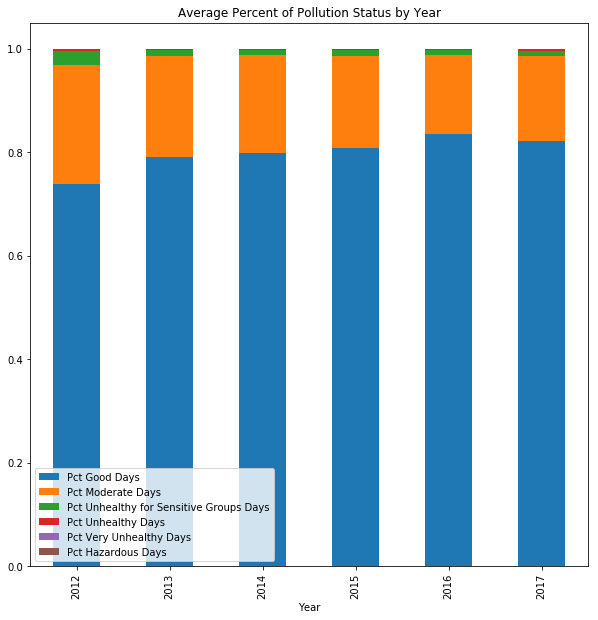

In [30]:
#Create a dataframe organized by Year and the average percentages of each of the AQI levels
epa_data_year_pcts = epa_data.groupby(['Year'])['Pct Good Days', 'Pct Moderate Days',
       'Pct Unhealthy for Sensitive Groups Days', 'Pct Unhealthy Days',
       'Pct Very Unhealthy Days', 'Pct Hazardous Days'].mean()
#Plot the dataframe as stacked bar chart
epa_data_year_pcts.sort_values(by='Year', ascending=True).plot(kind='bar',stacked=True,figsize=(10,10),rot=90,title="Average Percent of Pollution Status by Year")

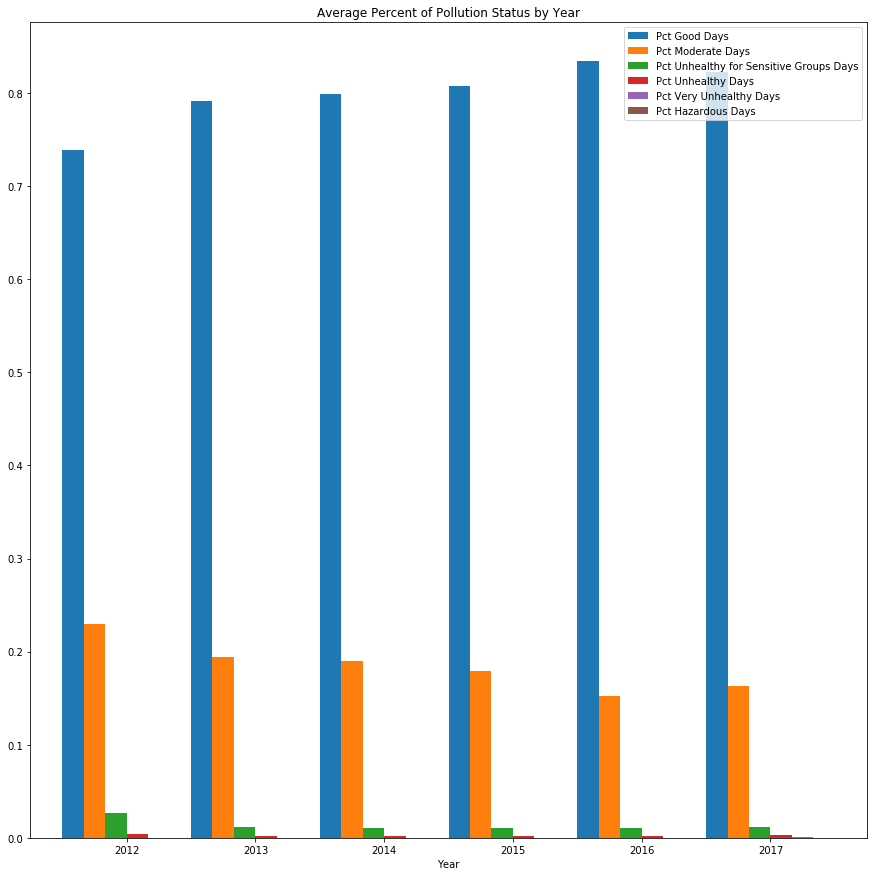

In [31]:
#Plot the dataframe as a bar chart
epa_data_year_pcts.sort_values(by='Year', ascending=True).plot(kind='bar',stacked=False,width=1,figsize=(15,15),rot=0,title="Average Percent of Pollution Status by Year")

In [68]:
#Doug's Code
# read in a dataframe and make a new column on this dataframe 
df = pd.read_csv("census_and_epa.csv")
df['PercentGoodDays'] = 100 * df['Good Days']/df['Days with AQI']

In [69]:
# Perform a linear regression on air quality and poverty variables and print the results
slope, intercept, r_value, p_value, std_err = linregress(df['PercentGoodDays'], df['PctBelowPoverty Population'])
print(f'slope: {slope}, intercept: {intercept}, r-value: {r_value}, p-value: {p_value},\nstandard error: {std_err}')

slope: -0.036057985212845915, intercept: 17.458817072809847, r-value: -0.1016960290788303, p-value: 7.028437507760651e-10,
standard error: 0.005832806007403754


Slope Interpretation¶

An increase in PercentGoodDays by 10% corresponds to a 3.6 percent decrease in the percent below poverty threshold

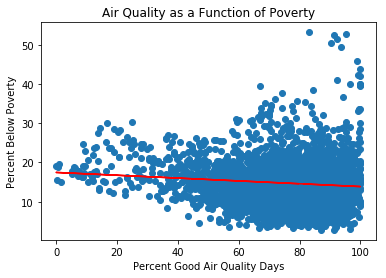

In [70]:
# Plot the relationship between air quality and poverty variables
plt.plot(df['PercentGoodDays'], df['PctBelowPoverty Population'], 'o', label='original data')
plt.plot(df['PercentGoodDays'], intercept + slope*df['PercentGoodDays'], 'r', label='fitted line')
plt.xlabel("Percent Good Air Quality Days")
plt.ylabel("Percent Below Poverty")
plt.title("Air Quality as a Function of Poverty")

plt.show()

In [71]:
# Examine this relationship for a single year
df_2012 = df[df['Year'] == 2012]
slope_12, intercept_12, r_value_12, p_value_12, std_err_12 = linregress(df_2012['PercentGoodDays'], df_2012['PctBelowPoverty Population'])

slope: -0.018876327388561782, intercept: 16.9663280084511, r-value: -0.054256418772535016, p-value: 0.1797347127999716,
standard error: 0.014054182851065862

the slope of the fitted line is not significantly different from zero for the 2012 data


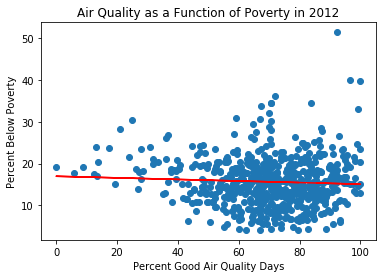

In [72]:
# Plot this relationship for a single year
plt.plot(df_2012['PercentGoodDays'], df_2012['PctBelowPoverty Population'], 'o', label='original data')
plt.plot(df_2012['PercentGoodDays'], intercept_12 + slope_12*df_2012['PercentGoodDays'], 'r', label='fitted line')
plt.xlabel("Percent Good Air Quality Days")
plt.ylabel("Percent Below Poverty")
plt.title("Air Quality as a Function of Poverty in 2012")

print(f'slope: {slope_12}, intercept: {intercept_12}, r-value: {r_value_12}, p-value: {p_value_12},\nstandard error: {std_err_12}')
print(f'\nthe slope of the fitted line is not significantly different from zero for the 2012 data')

slope: -0.027743549373413594, intercept: 15.404087676857682, r-value: -0.07718122233134318, p-value: 0.05655482981975833,
standard error: 0.014522598198439634

the slope of the fitted line is not significantly different from zero for the 2017 data


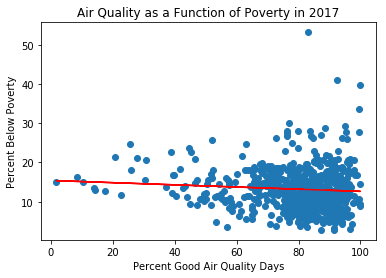

In [73]:
#Examine and plot this relationship for another year
df_2017 = df[df['Year'] == 2017]
slope_17, intercept_17, r_value_17, p_value_17, std_err_17 = linregress(df_2017['PercentGoodDays'], df_2017['PctBelowPoverty Population'])
plt.plot(df_2017['PercentGoodDays'], df_2017['PctBelowPoverty Population'], 'o', label='original data')
plt.plot(df_2017['PercentGoodDays'], intercept_17 + slope_17*df_2017['PercentGoodDays'], 'r', label='fitted line')
plt.xlabel("Percent Good Air Quality Days")
plt.ylabel("Percent Below Poverty")
plt.title("Air Quality as a Function of Poverty in 2017")

print(f'slope: {slope_17}, intercept: {intercept_17}, r-value: {r_value_17}, p-value: {p_value_17},\nstandard error: {std_err_17}')
print(f'\nthe slope of the fitted line is not significantly different from zero for the 2017 data')

In [ ]:
#Scott's Code

In [39]:
#Justin's Code
justin_df = pd.read_csv("census_and_epa.csv")
justin_df

#drop a couple columns that I don't plan to use and make a dataframe with only the variables I'm interested in analyzing
justin_df.drop(columns=['Total Male', 'Total Female', 'PctBelowPoverty Male', 'PctBelowPoverty Female', 'Unnamed: 0', 'Unnamed: 0.1'])
poverty_by_year_df = justin_df[['Year', 'PctBelowPoverty Population']]

# group some variables together to eventually make a dataframe
year_grouped_series = poverty_by_year_df.groupby(['Year'])
year_list = poverty_by_year_df['Year'].unique()
percent_poverty = year_grouped_series["PctBelowPoverty Population"].mean()

final_poverty_grouped_df = pd.DataFrame({"year": year_list, "Percent Below Poverty": percent_poverty})

# make some variables in preparation for making an easy-to-navigate graph
x_axis = year_list
poverty_points = final_poverty_grouped_df['Percent Below Poverty']


In [40]:
# group some variables together to make a dataframe
AQI_by_year_df = justin_df[['Year', 'Median AQI']]
year_grouped_series_AQI = AQI_by_year_df.groupby(['Year'])

median_AQI_series = year_grouped_series_AQI["Median AQI"].mean()

final_AQI_grouped_df = pd.DataFrame({"year": year_list, "Median AQI": median_AQI_series})

# make another variable for use in graphing
AQI_points = final_AQI_grouped_df['Median AQI']

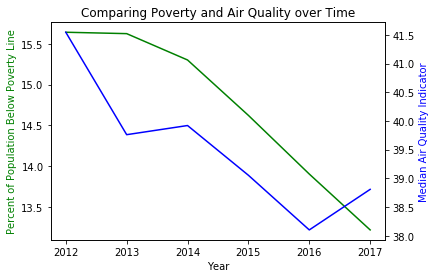

In [41]:
# making a graph with two y-axes comparing poverty and air quality
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x_axis, poverty_points, 'g-')
ax2.plot(x_axis, AQI_points, 'b-')



ax1.set_xlabel('Year')
ax1.set_ylabel('Percent of Population Below Poverty Line', color='g')
ax2.set_ylabel('Median Air Quality Indicator', color='b')
plt.title('Comparing Poverty and Air Quality over Time')
plt.savefig('poverty vs air quality plot', dpi=200)
plt.show()